In [87]:
import sys
sys.path.append('scripts')

In [152]:
import logging
import glob
import pandas as pd
import nltk
import os

import gensim
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models.callbacks import PerplexityMetric
from gensim.models.wrappers import LdaMallet
from utils import is_punct

TOKENIZER = nltk.tokenize.word_tokenize

In [153]:
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

In [165]:
CORPUS_PATH = 'VARDnormalized/varded50/*.txt'
stop_words_path = '/Users/alielassche/applications/mallet/stoplists/stoplist_vard.txt'
stop_words = [s.lower() for s in open(stop_words_path, 'r', encoding='utf-8').read().splitlines()]

MIN_DF = 20 # minimum document frequency
MAX_DF = 0.8 #maximum document frequency

N_TOPICS = 70
ITERATIONS = 2000
OPTIMIZE_INTERVAL = 20
EVAL_EVERY = 3 # for regular LDA 
N_WORKERS = 3 # number of CPU'S for multiprocessing

In [163]:
remove_stopwords = lambda x: [word.lower() for word in x if word.lower() not in stop_words and not is_punct(word) and len(word) > 1]

texts = glob.glob(CORPUS_PATH, recursive=False)
tokenized_texts = [TOKENIZER(open(text, "r", encoding="utf-8").read(), language="dutch") for text in texts]
tokenized_texts = [remove_stopwords(text) for text in tokenized_texts]

In [164]:
dictionary = Dictionary(tokenized_texts)
dictionary.filter_extremes(no_below=MIN_DF, no_above=MAX_DF)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

INFO : adding document #0 to Dictionary(0 unique tokens: [])
INFO : adding document #10000 to Dictionary(118268 unique tokens: ['aards', 'aartsverraders', 'af', 'binden', 'blixemvuur']...)
INFO : adding document #20000 to Dictionary(181352 unique tokens: ['aards', 'aartsverraders', 'af', 'binden', 'blixemvuur']...)
INFO : built Dictionary(194168 unique tokens: ['aards', 'aartsverraders', 'af', 'binden', 'blixemvuur']...) from 22297 documents (total 3175694 corpus positions)
INFO : discarding 181967 tokens: [('aartsverraders', 1), ('blixemvuur', 1), ('bruissend', 1), ('element', 19), ('gadeslaan', 4), ('hemelvieren', 1), ('mindre', 4), ('noordewinden', 2), ('stargewelf', 4), ('zinkt', 15)]...
INFO : keeping 12201 tokens which were in no less than 20 and no more than 17837 (=80.0%) documents
INFO : resulting dictionary: Dictionary(12201 unique tokens: ['aards', 'af', 'binden', 'dag', 'durft']...)


In [166]:
lda = LdaMallet('/Users/alielassche/applications/mallet/bin/mallet', 
                corpus=corpus,
                id2word=dictionary,
                num_topics=N_TOPICS, 
                iterations=ITERATIONS,  
                workers=N_WORKERS,
                optimize_interval=OPTIMIZE_INTERVAL)

INFO : serializing temporary corpus to /var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/a8b7b8_corpus.txt
INFO : converting temporary corpus to MALLET format with /Users/alielassche/applications/mallet/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/a8b7b8_corpus.txt --output /var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/a8b7b8_corpus.mallet
INFO : training MALLET LDA with /Users/alielassche/applications/mallet/bin/mallet train-topics --input /var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/a8b7b8_corpus.mallet --num-topics 70  --alpha 50 --optimize-interval 20 --num-threads 3 --output-state /var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/a8b7b8_state.mallet.gz --output-doc-topics /var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/a8b7b8_doctopics.txt --output-topic-keys /var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/a8b7b8_topickeys.txt --num-iterations 2000 --inferencer-filename

In [46]:
#lda.show_topics(formatted=False)

[(0,
  [('viva', 0.04721030042918455),
   ('onze', 0.022174535050071532),
   ('lof', 0.015736766809728183),
   ('hemel', 0.015021459227467811),
   ('grote', 0.01430615164520744),
   ('toch', 0.013590844062947067),
   ('stem', 0.012875536480686695),
   ('dies', 0.012160228898426323),
   ('godes', 0.012160228898426323),
   ('wereld', 0.011444921316165951)]),
 (1,
  [('god', 0.05034182722187694),
   ('gods', 0.030453697949036667),
   ('heer', 0.026724673710379118),
   ('eeuwig', 0.016159105034182723),
   ('och', 0.01305158483530143),
   ('rein', 0.01305158483530143),
   ('recht', 0.012430080795525171),
   ('zonden', 0.012430080795525171),
   ('geloof', 0.011187072715972654),
   ('altijd', 0.009944064636420136)]),
 (2,
  [('hert', 0.029277813923227064),
   ('ach', 0.02081977878985036),
   ("'k", 0.020169160702667534),
   ('nooit', 0.020169160702667534),
   ('pijn', 0.01626545217957059),
   ('min', 0.014964216005204945),
   ('lief', 0.013662979830839297),
   ('mee', 0.01236174365647365),
  

In [167]:
from gensim.models import CoherenceModel
coherence_model_ldamallet = CoherenceModel(model=lda, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO : 1 batches submitted to accumulate stats from 64 documents (1901 virtual)
INFO : 2 batches submitted to accumulate stats from 128 documents (4356 virtual)
INFO : 3 batches submitted to accumulate stats from 192 documents (5223 virtual)
INFO : 4 batches submitted to accumulate stats from 256 documents (8007 virtual)
INFO : 5 batches submitted to accumulate stats from 320 documents (10193 virtual)
INFO : 6 batches submitted to accumulate stats from 384 documents (13995 virtual)
INFO : 7 batches submitted to accumulate stats from 448 documents (16951 virtual)
INFO : 8 batches submitted to accumulate stats from 512 documents (17240 virtual)
INFO : 9 batches submitted to accumulate stats from 576 documents (19354 virtual)
INFO : 10 batches submitted to accumulate stats from 640 documents (21755 virtual)
INFO : 11 batches submitted to accumulate stats from 704 docum

INFO : 97 batches submitted to accumulate stats from 6208 documents (210151 virtual)
INFO : 98 batches submitted to accumulate stats from 6272 documents (213170 virtual)
INFO : 99 batches submitted to accumulate stats from 6336 documents (216145 virtual)
INFO : 100 batches submitted to accumulate stats from 6400 documents (216811 virtual)
INFO : 101 batches submitted to accumulate stats from 6464 documents (219041 virtual)
INFO : 102 batches submitted to accumulate stats from 6528 documents (221635 virtual)
INFO : 103 batches submitted to accumulate stats from 6592 documents (224255 virtual)
INFO : 104 batches submitted to accumulate stats from 6656 documents (226688 virtual)
INFO : 105 batches submitted to accumulate stats from 6720 documents (228667 virtual)
INFO : 106 batches submitted to accumulate stats from 6784 documents (230396 virtual)
INFO : 107 batches submitted to accumulate stats from 6848 documents (232366 virtual)
INFO : 108 batches submitted to accumulate stats from 691

INFO : 193 batches submitted to accumulate stats from 12352 documents (411894 virtual)
INFO : 194 batches submitted to accumulate stats from 12416 documents (413963 virtual)
INFO : 195 batches submitted to accumulate stats from 12480 documents (415478 virtual)
INFO : 196 batches submitted to accumulate stats from 12544 documents (416174 virtual)
INFO : 197 batches submitted to accumulate stats from 12608 documents (418197 virtual)
INFO : 198 batches submitted to accumulate stats from 12672 documents (419540 virtual)
INFO : 199 batches submitted to accumulate stats from 12736 documents (421140 virtual)
INFO : 200 batches submitted to accumulate stats from 12800 documents (422999 virtual)
INFO : 201 batches submitted to accumulate stats from 12864 documents (426245 virtual)
INFO : 202 batches submitted to accumulate stats from 12928 documents (427386 virtual)
INFO : 203 batches submitted to accumulate stats from 12992 documents (430096 virtual)
INFO : 204 batches submitted to accumulate 

INFO : 288 batches submitted to accumulate stats from 18432 documents (614057 virtual)
INFO : 289 batches submitted to accumulate stats from 18496 documents (615125 virtual)
INFO : 290 batches submitted to accumulate stats from 18560 documents (616235 virtual)
INFO : 291 batches submitted to accumulate stats from 18624 documents (618147 virtual)
INFO : 292 batches submitted to accumulate stats from 18688 documents (621690 virtual)
INFO : 293 batches submitted to accumulate stats from 18752 documents (624686 virtual)
INFO : 294 batches submitted to accumulate stats from 18816 documents (626053 virtual)
INFO : 295 batches submitted to accumulate stats from 18880 documents (628647 virtual)
INFO : 296 batches submitted to accumulate stats from 18944 documents (630255 virtual)
INFO : 297 batches submitted to accumulate stats from 19008 documents (632890 virtual)
INFO : 298 batches submitted to accumulate stats from 19072 documents (636733 virtual)
INFO : 299 batches submitted to accumulate 


Coherence Score:  0.4788119178433067


In [168]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet('/Users/alielassche/applications/mallet/bin/mallet', corpus=corpus, num_topics=num_topics, id2word=dictionary, iterations=ITERATIONS,  
                workers=N_WORKERS, optimize_interval=OPTIMIZE_INTERVAL)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [169]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=tokenized_texts, start=10, limit=110, step=10)

INFO : serializing temporary corpus to /var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/c227fa_corpus.txt
INFO : converting temporary corpus to MALLET format with /Users/alielassche/applications/mallet/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/c227fa_corpus.txt --output /var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/c227fa_corpus.mallet
INFO : training MALLET LDA with /Users/alielassche/applications/mallet/bin/mallet train-topics --input /var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/c227fa_corpus.mallet --num-topics 10  --alpha 50 --optimize-interval 20 --num-threads 3 --output-state /var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/c227fa_state.mallet.gz --output-doc-topics /var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/c227fa_doctopics.txt --output-topic-keys /var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/c227fa_topickeys.txt --num-iterations 2000 --inferencer-filename

INFO : 83 batches submitted to accumulate stats from 5312 documents (181676 virtual)
INFO : 84 batches submitted to accumulate stats from 5376 documents (183428 virtual)
INFO : 85 batches submitted to accumulate stats from 5440 documents (187277 virtual)
INFO : 86 batches submitted to accumulate stats from 5504 documents (190502 virtual)
INFO : 87 batches submitted to accumulate stats from 5568 documents (191343 virtual)
INFO : 88 batches submitted to accumulate stats from 5632 documents (193727 virtual)
INFO : 89 batches submitted to accumulate stats from 5696 documents (196360 virtual)
INFO : 90 batches submitted to accumulate stats from 5760 documents (198135 virtual)
INFO : 91 batches submitted to accumulate stats from 5824 documents (199107 virtual)
INFO : 92 batches submitted to accumulate stats from 5888 documents (200905 virtual)
INFO : 93 batches submitted to accumulate stats from 5952 documents (202299 virtual)
INFO : 94 batches submitted to accumulate stats from 6016 documen

INFO : 179 batches submitted to accumulate stats from 11456 documents (378858 virtual)
INFO : 180 batches submitted to accumulate stats from 11520 documents (379536 virtual)
INFO : 181 batches submitted to accumulate stats from 11584 documents (380224 virtual)
INFO : 182 batches submitted to accumulate stats from 11648 documents (382545 virtual)
INFO : 183 batches submitted to accumulate stats from 11712 documents (385096 virtual)
INFO : 184 batches submitted to accumulate stats from 11776 documents (388991 virtual)
INFO : 185 batches submitted to accumulate stats from 11840 documents (392685 virtual)
INFO : 186 batches submitted to accumulate stats from 11904 documents (395584 virtual)
INFO : 187 batches submitted to accumulate stats from 11968 documents (397889 virtual)
INFO : 188 batches submitted to accumulate stats from 12032 documents (404090 virtual)
INFO : 189 batches submitted to accumulate stats from 12096 documents (406747 virtual)
INFO : 190 batches submitted to accumulate 

INFO : 273 batches submitted to accumulate stats from 17472 documents (589330 virtual)
INFO : 274 batches submitted to accumulate stats from 17536 documents (591615 virtual)
INFO : 275 batches submitted to accumulate stats from 17600 documents (593632 virtual)
INFO : 276 batches submitted to accumulate stats from 17664 documents (595751 virtual)
INFO : 277 batches submitted to accumulate stats from 17728 documents (598585 virtual)
INFO : 278 batches submitted to accumulate stats from 17792 documents (600447 virtual)
INFO : 279 batches submitted to accumulate stats from 17856 documents (601674 virtual)
INFO : 280 batches submitted to accumulate stats from 17920 documents (603387 virtual)
INFO : 281 batches submitted to accumulate stats from 17984 documents (604241 virtual)
INFO : 282 batches submitted to accumulate stats from 18048 documents (605928 virtual)
INFO : 283 batches submitted to accumulate stats from 18112 documents (607551 virtual)
INFO : 284 batches submitted to accumulate 

INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO : 1 batches submitted to accumulate stats from 64 documents (1901 virtual)
INFO : 2 batches submitted to accumulate stats from 128 documents (4356 virtual)
INFO : 3 batches submitted to accumulate stats from 192 documents (5223 virtual)
INFO : 4 batches submitted to accumulate stats from 256 documents (8007 virtual)
INFO : 5 batches submitted to accumulate stats from 320 documents (10193 virtual)
INFO : 6 batches submitted to accumulate stats from 384 documents (13995 virtual)
INFO : 7 batches submitted to accumulate stats from 448 documents (16951 virtual)
INFO : 8 batches submitted to accumulate stats from 512 documents (17240 virtual)
INFO : 9 batches submitted to accumulate stats from 576 documents (19354 virtual)
INFO : 10 batches submitted to accumulate stats from 640 documents (21755 virtual)
INFO : 11 batches submitted to accumulate stats from 704 docum

INFO : 97 batches submitted to accumulate stats from 6208 documents (210838 virtual)
INFO : 98 batches submitted to accumulate stats from 6272 documents (213793 virtual)
INFO : 99 batches submitted to accumulate stats from 6336 documents (216284 virtual)
INFO : 100 batches submitted to accumulate stats from 6400 documents (217363 virtual)
INFO : 101 batches submitted to accumulate stats from 6464 documents (219987 virtual)
INFO : 102 batches submitted to accumulate stats from 6528 documents (221987 virtual)
INFO : 103 batches submitted to accumulate stats from 6592 documents (224871 virtual)
INFO : 104 batches submitted to accumulate stats from 6656 documents (227136 virtual)
INFO : 105 batches submitted to accumulate stats from 6720 documents (229371 virtual)
INFO : 106 batches submitted to accumulate stats from 6784 documents (230957 virtual)
INFO : 107 batches submitted to accumulate stats from 6848 documents (232885 virtual)
INFO : 108 batches submitted to accumulate stats from 691

INFO : 192 batches submitted to accumulate stats from 12288 documents (410413 virtual)
INFO : 193 batches submitted to accumulate stats from 12352 documents (412790 virtual)
INFO : 194 batches submitted to accumulate stats from 12416 documents (414965 virtual)
INFO : 195 batches submitted to accumulate stats from 12480 documents (416364 virtual)
INFO : 196 batches submitted to accumulate stats from 12544 documents (417090 virtual)
INFO : 197 batches submitted to accumulate stats from 12608 documents (419160 virtual)
INFO : 198 batches submitted to accumulate stats from 12672 documents (420447 virtual)
INFO : 199 batches submitted to accumulate stats from 12736 documents (421991 virtual)
INFO : 200 batches submitted to accumulate stats from 12800 documents (424733 virtual)
INFO : 201 batches submitted to accumulate stats from 12864 documents (427217 virtual)
INFO : 202 batches submitted to accumulate stats from 12928 documents (428380 virtual)
INFO : 203 batches submitted to accumulate 

INFO : 287 batches submitted to accumulate stats from 18368 documents (612696 virtual)
INFO : 288 batches submitted to accumulate stats from 18432 documents (615404 virtual)
INFO : 289 batches submitted to accumulate stats from 18496 documents (616555 virtual)
INFO : 290 batches submitted to accumulate stats from 18560 documents (617979 virtual)
INFO : 291 batches submitted to accumulate stats from 18624 documents (620758 virtual)
INFO : 292 batches submitted to accumulate stats from 18688 documents (623888 virtual)
INFO : 293 batches submitted to accumulate stats from 18752 documents (626396 virtual)
INFO : 294 batches submitted to accumulate stats from 18816 documents (628173 virtual)
INFO : 295 batches submitted to accumulate stats from 18880 documents (630082 virtual)
INFO : 296 batches submitted to accumulate stats from 18944 documents (632529 virtual)
INFO : 297 batches submitted to accumulate stats from 19008 documents (635804 virtual)
INFO : 298 batches submitted to accumulate 

INFO : 15 batches submitted to accumulate stats from 960 documents (30426 virtual)
INFO : 16 batches submitted to accumulate stats from 1024 documents (32213 virtual)
INFO : 17 batches submitted to accumulate stats from 1088 documents (34566 virtual)
INFO : 18 batches submitted to accumulate stats from 1152 documents (37554 virtual)
INFO : 19 batches submitted to accumulate stats from 1216 documents (40305 virtual)
INFO : 20 batches submitted to accumulate stats from 1280 documents (42333 virtual)
INFO : 21 batches submitted to accumulate stats from 1344 documents (44449 virtual)
INFO : 22 batches submitted to accumulate stats from 1408 documents (45730 virtual)
INFO : 23 batches submitted to accumulate stats from 1472 documents (48312 virtual)
INFO : 24 batches submitted to accumulate stats from 1536 documents (50536 virtual)
INFO : 25 batches submitted to accumulate stats from 1600 documents (51655 virtual)
INFO : 26 batches submitted to accumulate stats from 1664 documents (52335 vi

INFO : 112 batches submitted to accumulate stats from 7168 documents (237588 virtual)
INFO : 113 batches submitted to accumulate stats from 7232 documents (238378 virtual)
INFO : 114 batches submitted to accumulate stats from 7296 documents (241993 virtual)
INFO : 115 batches submitted to accumulate stats from 7360 documents (243506 virtual)
INFO : 116 batches submitted to accumulate stats from 7424 documents (246129 virtual)
INFO : 117 batches submitted to accumulate stats from 7488 documents (249444 virtual)
INFO : 118 batches submitted to accumulate stats from 7552 documents (250898 virtual)
INFO : 119 batches submitted to accumulate stats from 7616 documents (254064 virtual)
INFO : 120 batches submitted to accumulate stats from 7680 documents (256710 virtual)
INFO : 121 batches submitted to accumulate stats from 7744 documents (259251 virtual)
INFO : 122 batches submitted to accumulate stats from 7808 documents (262055 virtual)
INFO : 123 batches submitted to accumulate stats from 

INFO : 208 batches submitted to accumulate stats from 13312 documents (443324 virtual)
INFO : 209 batches submitted to accumulate stats from 13376 documents (446450 virtual)
INFO : 210 batches submitted to accumulate stats from 13440 documents (449095 virtual)
INFO : 211 batches submitted to accumulate stats from 13504 documents (451258 virtual)
INFO : 212 batches submitted to accumulate stats from 13568 documents (453409 virtual)
INFO : 213 batches submitted to accumulate stats from 13632 documents (455154 virtual)
INFO : 214 batches submitted to accumulate stats from 13696 documents (460148 virtual)
INFO : 215 batches submitted to accumulate stats from 13760 documents (462463 virtual)
INFO : 216 batches submitted to accumulate stats from 13824 documents (462870 virtual)
INFO : 217 batches submitted to accumulate stats from 13888 documents (464460 virtual)
INFO : 218 batches submitted to accumulate stats from 13952 documents (465663 virtual)
INFO : 219 batches submitted to accumulate 

INFO : 303 batches submitted to accumulate stats from 19392 documents (650271 virtual)
INFO : 304 batches submitted to accumulate stats from 19456 documents (651849 virtual)
INFO : 305 batches submitted to accumulate stats from 19520 documents (653298 virtual)
INFO : 306 batches submitted to accumulate stats from 19584 documents (655358 virtual)
INFO : 307 batches submitted to accumulate stats from 19648 documents (657726 virtual)
INFO : 308 batches submitted to accumulate stats from 19712 documents (659618 virtual)
INFO : 309 batches submitted to accumulate stats from 19776 documents (662904 virtual)
INFO : 310 batches submitted to accumulate stats from 19840 documents (665699 virtual)
INFO : 311 batches submitted to accumulate stats from 19904 documents (667143 virtual)
INFO : 312 batches submitted to accumulate stats from 19968 documents (669949 virtual)
INFO : 313 batches submitted to accumulate stats from 20032 documents (672576 virtual)
INFO : 314 batches submitted to accumulate 

INFO : 30 batches submitted to accumulate stats from 1920 documents (60120 virtual)
INFO : 31 batches submitted to accumulate stats from 1984 documents (61330 virtual)
INFO : 32 batches submitted to accumulate stats from 2048 documents (64241 virtual)
INFO : 33 batches submitted to accumulate stats from 2112 documents (67362 virtual)
INFO : 34 batches submitted to accumulate stats from 2176 documents (69351 virtual)
INFO : 35 batches submitted to accumulate stats from 2240 documents (71628 virtual)
INFO : 36 batches submitted to accumulate stats from 2304 documents (72690 virtual)
INFO : 37 batches submitted to accumulate stats from 2368 documents (74641 virtual)
INFO : 38 batches submitted to accumulate stats from 2432 documents (76210 virtual)
INFO : 39 batches submitted to accumulate stats from 2496 documents (78164 virtual)
INFO : 40 batches submitted to accumulate stats from 2560 documents (80002 virtual)
INFO : 41 batches submitted to accumulate stats from 2624 documents (82067 v

INFO : 127 batches submitted to accumulate stats from 8128 documents (272764 virtual)
INFO : 128 batches submitted to accumulate stats from 8192 documents (275023 virtual)
INFO : 129 batches submitted to accumulate stats from 8256 documents (277020 virtual)
INFO : 130 batches submitted to accumulate stats from 8320 documents (278052 virtual)
INFO : 131 batches submitted to accumulate stats from 8384 documents (278691 virtual)
INFO : 132 batches submitted to accumulate stats from 8448 documents (280365 virtual)
INFO : 133 batches submitted to accumulate stats from 8512 documents (281584 virtual)
INFO : 134 batches submitted to accumulate stats from 8576 documents (282134 virtual)
INFO : 135 batches submitted to accumulate stats from 8640 documents (283772 virtual)
INFO : 136 batches submitted to accumulate stats from 8704 documents (285493 virtual)
INFO : 137 batches submitted to accumulate stats from 8768 documents (287067 virtual)
INFO : 138 batches submitted to accumulate stats from 

INFO : 223 batches submitted to accumulate stats from 14272 documents (476577 virtual)
INFO : 224 batches submitted to accumulate stats from 14336 documents (478572 virtual)
INFO : 225 batches submitted to accumulate stats from 14400 documents (479954 virtual)
INFO : 226 batches submitted to accumulate stats from 14464 documents (482085 virtual)
INFO : 227 batches submitted to accumulate stats from 14528 documents (488270 virtual)
INFO : 228 batches submitted to accumulate stats from 14592 documents (490665 virtual)
INFO : 229 batches submitted to accumulate stats from 14656 documents (492233 virtual)
INFO : 230 batches submitted to accumulate stats from 14720 documents (494473 virtual)
INFO : 231 batches submitted to accumulate stats from 14784 documents (499394 virtual)
INFO : 232 batches submitted to accumulate stats from 14848 documents (501594 virtual)
INFO : 233 batches submitted to accumulate stats from 14912 documents (504609 virtual)
INFO : 234 batches submitted to accumulate 

INFO : 318 batches submitted to accumulate stats from 20352 documents (683757 virtual)
INFO : 319 batches submitted to accumulate stats from 20416 documents (686362 virtual)
INFO : 320 batches submitted to accumulate stats from 20480 documents (688885 virtual)
INFO : 321 batches submitted to accumulate stats from 20544 documents (691070 virtual)
INFO : 322 batches submitted to accumulate stats from 20608 documents (692836 virtual)
INFO : 323 batches submitted to accumulate stats from 20672 documents (695214 virtual)
INFO : 324 batches submitted to accumulate stats from 20736 documents (696219 virtual)
INFO : 325 batches submitted to accumulate stats from 20800 documents (697571 virtual)
INFO : 326 batches submitted to accumulate stats from 20864 documents (699637 virtual)
INFO : 327 batches submitted to accumulate stats from 20928 documents (701593 virtual)
INFO : 328 batches submitted to accumulate stats from 20992 documents (704349 virtual)
INFO : 329 batches submitted to accumulate 

INFO : 46 batches submitted to accumulate stats from 2944 documents (93055 virtual)
INFO : 47 batches submitted to accumulate stats from 3008 documents (96747 virtual)
INFO : 48 batches submitted to accumulate stats from 3072 documents (100805 virtual)
INFO : 49 batches submitted to accumulate stats from 3136 documents (101629 virtual)
INFO : 50 batches submitted to accumulate stats from 3200 documents (105642 virtual)
INFO : 51 batches submitted to accumulate stats from 3264 documents (107149 virtual)
INFO : 52 batches submitted to accumulate stats from 3328 documents (108900 virtual)
INFO : 53 batches submitted to accumulate stats from 3392 documents (111941 virtual)
INFO : 54 batches submitted to accumulate stats from 3456 documents (116881 virtual)
INFO : 55 batches submitted to accumulate stats from 3520 documents (118680 virtual)
INFO : 56 batches submitted to accumulate stats from 3584 documents (120583 virtual)
INFO : 57 batches submitted to accumulate stats from 3648 documents

INFO : 142 batches submitted to accumulate stats from 9088 documents (298129 virtual)
INFO : 143 batches submitted to accumulate stats from 9152 documents (300091 virtual)
INFO : 144 batches submitted to accumulate stats from 9216 documents (302576 virtual)
INFO : 145 batches submitted to accumulate stats from 9280 documents (306715 virtual)
INFO : 146 batches submitted to accumulate stats from 9344 documents (308382 virtual)
INFO : 147 batches submitted to accumulate stats from 9408 documents (310147 virtual)
INFO : 148 batches submitted to accumulate stats from 9472 documents (312014 virtual)
INFO : 149 batches submitted to accumulate stats from 9536 documents (313280 virtual)
INFO : 150 batches submitted to accumulate stats from 9600 documents (313902 virtual)
INFO : 151 batches submitted to accumulate stats from 9664 documents (315845 virtual)
INFO : 152 batches submitted to accumulate stats from 9728 documents (316923 virtual)
INFO : 153 batches submitted to accumulate stats from 

INFO : 238 batches submitted to accumulate stats from 15232 documents (514712 virtual)
INFO : 239 batches submitted to accumulate stats from 15296 documents (516356 virtual)
INFO : 240 batches submitted to accumulate stats from 15360 documents (517089 virtual)
INFO : 241 batches submitted to accumulate stats from 15424 documents (517885 virtual)
INFO : 242 batches submitted to accumulate stats from 15488 documents (519866 virtual)
INFO : 243 batches submitted to accumulate stats from 15552 documents (521142 virtual)
INFO : 244 batches submitted to accumulate stats from 15616 documents (524562 virtual)
INFO : 245 batches submitted to accumulate stats from 15680 documents (527046 virtual)
INFO : 246 batches submitted to accumulate stats from 15744 documents (529012 virtual)
INFO : 247 batches submitted to accumulate stats from 15808 documents (531709 virtual)
INFO : 248 batches submitted to accumulate stats from 15872 documents (534570 virtual)
INFO : 249 batches submitted to accumulate 

INFO : 333 batches submitted to accumulate stats from 21312 documents (712655 virtual)
INFO : 334 batches submitted to accumulate stats from 21376 documents (714614 virtual)
INFO : 335 batches submitted to accumulate stats from 21440 documents (717533 virtual)
INFO : 336 batches submitted to accumulate stats from 21504 documents (719815 virtual)
INFO : 337 batches submitted to accumulate stats from 21568 documents (721315 virtual)
INFO : 338 batches submitted to accumulate stats from 21632 documents (724633 virtual)
INFO : 339 batches submitted to accumulate stats from 21696 documents (727649 virtual)
INFO : 340 batches submitted to accumulate stats from 21760 documents (729030 virtual)
INFO : 341 batches submitted to accumulate stats from 21824 documents (734213 virtual)
INFO : 342 batches submitted to accumulate stats from 21888 documents (736087 virtual)
INFO : 343 batches submitted to accumulate stats from 21952 documents (737044 virtual)
INFO : 344 batches submitted to accumulate 

INFO : 61 batches submitted to accumulate stats from 3904 documents (129760 virtual)
INFO : 62 batches submitted to accumulate stats from 3968 documents (131245 virtual)
INFO : 63 batches submitted to accumulate stats from 4032 documents (133192 virtual)
INFO : 64 batches submitted to accumulate stats from 4096 documents (134576 virtual)
INFO : 65 batches submitted to accumulate stats from 4160 documents (139146 virtual)
INFO : 66 batches submitted to accumulate stats from 4224 documents (142002 virtual)
INFO : 67 batches submitted to accumulate stats from 4288 documents (146560 virtual)
INFO : 68 batches submitted to accumulate stats from 4352 documents (148100 virtual)
INFO : 69 batches submitted to accumulate stats from 4416 documents (148727 virtual)
INFO : 70 batches submitted to accumulate stats from 4480 documents (150541 virtual)
INFO : 71 batches submitted to accumulate stats from 4544 documents (153040 virtual)
INFO : 72 batches submitted to accumulate stats from 4608 documen

INFO : 157 batches submitted to accumulate stats from 10048 documents (323911 virtual)
INFO : 158 batches submitted to accumulate stats from 10112 documents (325386 virtual)
INFO : 159 batches submitted to accumulate stats from 10176 documents (335030 virtual)
INFO : 160 batches submitted to accumulate stats from 10240 documents (338028 virtual)
INFO : 161 batches submitted to accumulate stats from 10304 documents (339223 virtual)
INFO : 162 batches submitted to accumulate stats from 10368 documents (341162 virtual)
INFO : 163 batches submitted to accumulate stats from 10432 documents (343401 virtual)
INFO : 164 batches submitted to accumulate stats from 10496 documents (346803 virtual)
INFO : 165 batches submitted to accumulate stats from 10560 documents (350805 virtual)
INFO : 166 batches submitted to accumulate stats from 10624 documents (352631 virtual)
INFO : 167 batches submitted to accumulate stats from 10688 documents (356339 virtual)
INFO : 168 batches submitted to accumulate 

INFO : 253 batches submitted to accumulate stats from 16192 documents (548424 virtual)
INFO : 254 batches submitted to accumulate stats from 16256 documents (550298 virtual)
INFO : 255 batches submitted to accumulate stats from 16320 documents (552628 virtual)
INFO : 256 batches submitted to accumulate stats from 16384 documents (554549 virtual)
INFO : 257 batches submitted to accumulate stats from 16448 documents (556525 virtual)
INFO : 258 batches submitted to accumulate stats from 16512 documents (557663 virtual)
INFO : 259 batches submitted to accumulate stats from 16576 documents (559277 virtual)
INFO : 260 batches submitted to accumulate stats from 16640 documents (560725 virtual)
INFO : 261 batches submitted to accumulate stats from 16704 documents (562235 virtual)
INFO : 262 batches submitted to accumulate stats from 16768 documents (565624 virtual)
INFO : 263 batches submitted to accumulate stats from 16832 documents (566723 virtual)
INFO : 264 batches submitted to accumulate 

INFO : 348 batches submitted to accumulate stats from 22272 documents (745573 virtual)
INFO : 349 batches submitted to accumulate stats from 22336 documents (745797 virtual)
INFO : serializing accumulator to return to master...
INFO : accumulator serialized
INFO : serializing accumulator to return to master...
INFO : serializing accumulator to return to master...
INFO : accumulator serialized
INFO : accumulator serialized
INFO : 3 accumulators retrieved from output queue
INFO : accumulated word occurrence stats for 1077862 virtual documents
INFO : serializing temporary corpus to /var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/beed44_corpus.txt
INFO : converting temporary corpus to MALLET format with /Users/alielassche/applications/mallet/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/beed44_corpus.txt --output /var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/beed44_corpus.mallet
INF

INFO : 76 batches submitted to accumulate stats from 4864 documents (164265 virtual)
INFO : 77 batches submitted to accumulate stats from 4928 documents (166727 virtual)
INFO : 78 batches submitted to accumulate stats from 4992 documents (170413 virtual)
INFO : 79 batches submitted to accumulate stats from 5056 documents (171644 virtual)
INFO : 80 batches submitted to accumulate stats from 5120 documents (175391 virtual)
INFO : 81 batches submitted to accumulate stats from 5184 documents (177458 virtual)
INFO : 82 batches submitted to accumulate stats from 5248 documents (178636 virtual)
INFO : 83 batches submitted to accumulate stats from 5312 documents (180132 virtual)
INFO : 84 batches submitted to accumulate stats from 5376 documents (182315 virtual)
INFO : 85 batches submitted to accumulate stats from 5440 documents (185377 virtual)
INFO : 86 batches submitted to accumulate stats from 5504 documents (188729 virtual)
INFO : 87 batches submitted to accumulate stats from 5568 documen

INFO : 172 batches submitted to accumulate stats from 11008 documents (367007 virtual)
INFO : 173 batches submitted to accumulate stats from 11072 documents (367886 virtual)
INFO : 174 batches submitted to accumulate stats from 11136 documents (368392 virtual)
INFO : 175 batches submitted to accumulate stats from 11200 documents (369350 virtual)
INFO : 176 batches submitted to accumulate stats from 11264 documents (370112 virtual)
INFO : 177 batches submitted to accumulate stats from 11328 documents (372668 virtual)
INFO : 178 batches submitted to accumulate stats from 11392 documents (374186 virtual)
INFO : 179 batches submitted to accumulate stats from 11456 documents (376255 virtual)
INFO : 180 batches submitted to accumulate stats from 11520 documents (377704 virtual)
INFO : 182 batches submitted to accumulate stats from 11648 documents (380449 virtual)
INFO : 183 batches submitted to accumulate stats from 11712 documents (382110 virtual)
INFO : 184 batches submitted to accumulate 

INFO : 268 batches submitted to accumulate stats from 17152 documents (575563 virtual)
INFO : 269 batches submitted to accumulate stats from 17216 documents (577922 virtual)
INFO : 270 batches submitted to accumulate stats from 17280 documents (579981 virtual)
INFO : 271 batches submitted to accumulate stats from 17344 documents (581609 virtual)
INFO : 272 batches submitted to accumulate stats from 17408 documents (583166 virtual)
INFO : 273 batches submitted to accumulate stats from 17472 documents (584924 virtual)
INFO : 274 batches submitted to accumulate stats from 17536 documents (586988 virtual)
INFO : 275 batches submitted to accumulate stats from 17600 documents (588363 virtual)
INFO : 276 batches submitted to accumulate stats from 17664 documents (590803 virtual)
INFO : 277 batches submitted to accumulate stats from 17728 documents (592976 virtual)
INFO : 278 batches submitted to accumulate stats from 17792 documents (595588 virtual)
INFO : 279 batches submitted to accumulate 

INFO : loading assigned topics from /var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/722dd_state.mallet.gz
INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
INFO : 1 batches submitted to accumulate stats from 64 documents (1901 virtual)
INFO : 2 batches submitted to accumulate stats from 128 documents (4356 virtual)
INFO : 3 batches submitted to accumulate stats from 192 documents (5223 virtual)
INFO : 4 batches submitted to accumulate stats from 256 documents (8007 virtual)
INFO : 5 batches submitted to accumulate stats from 320 documents (10193 virtual)
INFO : 6 batches submitted to accumulate stats from 384 documents (13995 virtual)
INFO : 7 batches submitted to accumulate stats from 448 documents (16951 virtual)
INFO : 8 batches submitted to accumulate stats from 512 documents (17240 virtual)
INFO : 9 batches submitted to accumulate stats from 576 documents (19354 virtual)
INFO : 10 batches submitted to accumul

INFO : 96 batches submitted to accumulate stats from 6144 documents (207773 virtual)
INFO : 97 batches submitted to accumulate stats from 6208 documents (210151 virtual)
INFO : 98 batches submitted to accumulate stats from 6272 documents (213170 virtual)
INFO : 99 batches submitted to accumulate stats from 6336 documents (216145 virtual)
INFO : 100 batches submitted to accumulate stats from 6400 documents (216811 virtual)
INFO : 101 batches submitted to accumulate stats from 6464 documents (219041 virtual)
INFO : 102 batches submitted to accumulate stats from 6528 documents (221635 virtual)
INFO : 103 batches submitted to accumulate stats from 6592 documents (224255 virtual)
INFO : 104 batches submitted to accumulate stats from 6656 documents (226688 virtual)
INFO : 105 batches submitted to accumulate stats from 6720 documents (228667 virtual)
INFO : 106 batches submitted to accumulate stats from 6784 documents (230396 virtual)
INFO : 107 batches submitted to accumulate stats from 6848

INFO : 192 batches submitted to accumulate stats from 12288 documents (409493 virtual)
INFO : 193 batches submitted to accumulate stats from 12352 documents (411562 virtual)
INFO : 194 batches submitted to accumulate stats from 12416 documents (413816 virtual)
INFO : 195 batches submitted to accumulate stats from 12480 documents (415316 virtual)
INFO : 196 batches submitted to accumulate stats from 12544 documents (416020 virtual)
INFO : 197 batches submitted to accumulate stats from 12608 documents (418053 virtual)
INFO : 198 batches submitted to accumulate stats from 12672 documents (419454 virtual)
INFO : 199 batches submitted to accumulate stats from 12736 documents (421038 virtual)
INFO : 200 batches submitted to accumulate stats from 12800 documents (422696 virtual)
INFO : 201 batches submitted to accumulate stats from 12864 documents (426129 virtual)
INFO : 202 batches submitted to accumulate stats from 12928 documents (427176 virtual)
INFO : 203 batches submitted to accumulate 

INFO : 287 batches submitted to accumulate stats from 18368 documents (610257 virtual)
INFO : 288 batches submitted to accumulate stats from 18432 documents (613940 virtual)
INFO : 289 batches submitted to accumulate stats from 18496 documents (615023 virtual)
INFO : 290 batches submitted to accumulate stats from 18560 documents (616147 virtual)
INFO : 291 batches submitted to accumulate stats from 18624 documents (618048 virtual)
INFO : 292 batches submitted to accumulate stats from 18688 documents (621434 virtual)
INFO : 293 batches submitted to accumulate stats from 18752 documents (624540 virtual)
INFO : 294 batches submitted to accumulate stats from 18816 documents (625879 virtual)
INFO : 295 batches submitted to accumulate stats from 18880 documents (628550 virtual)
INFO : 296 batches submitted to accumulate stats from 18944 documents (630050 virtual)
INFO : 297 batches submitted to accumulate stats from 19008 documents (632644 virtual)
INFO : 298 batches submitted to accumulate 

INFO : 14 batches submitted to accumulate stats from 896 documents (28299 virtual)
INFO : 15 batches submitted to accumulate stats from 960 documents (30426 virtual)
INFO : 16 batches submitted to accumulate stats from 1024 documents (32213 virtual)
INFO : 17 batches submitted to accumulate stats from 1088 documents (34511 virtual)
INFO : 18 batches submitted to accumulate stats from 1152 documents (37498 virtual)
INFO : 19 batches submitted to accumulate stats from 1216 documents (39917 virtual)
INFO : 20 batches submitted to accumulate stats from 1280 documents (42204 virtual)
INFO : 21 batches submitted to accumulate stats from 1344 documents (44305 virtual)
INFO : 22 batches submitted to accumulate stats from 1408 documents (45689 virtual)
INFO : 23 batches submitted to accumulate stats from 1472 documents (48074 virtual)
INFO : 24 batches submitted to accumulate stats from 1536 documents (50455 virtual)
INFO : 25 batches submitted to accumulate stats from 1600 documents (51549 vir

INFO : 111 batches submitted to accumulate stats from 7104 documents (236942 virtual)
INFO : 112 batches submitted to accumulate stats from 7168 documents (237534 virtual)
INFO : 113 batches submitted to accumulate stats from 7232 documents (238325 virtual)
INFO : 114 batches submitted to accumulate stats from 7296 documents (241862 virtual)
INFO : 115 batches submitted to accumulate stats from 7360 documents (243424 virtual)
INFO : 116 batches submitted to accumulate stats from 7424 documents (246017 virtual)
INFO : 117 batches submitted to accumulate stats from 7488 documents (249396 virtual)
INFO : 118 batches submitted to accumulate stats from 7552 documents (250790 virtual)
INFO : 119 batches submitted to accumulate stats from 7616 documents (253683 virtual)
INFO : 120 batches submitted to accumulate stats from 7680 documents (256414 virtual)
INFO : 121 batches submitted to accumulate stats from 7744 documents (258998 virtual)
INFO : 122 batches submitted to accumulate stats from 

INFO : 207 batches submitted to accumulate stats from 13248 documents (441052 virtual)
INFO : 208 batches submitted to accumulate stats from 13312 documents (442524 virtual)
INFO : 209 batches submitted to accumulate stats from 13376 documents (445685 virtual)
INFO : 210 batches submitted to accumulate stats from 13440 documents (448386 virtual)
INFO : 211 batches submitted to accumulate stats from 13504 documents (450756 virtual)
INFO : 212 batches submitted to accumulate stats from 13568 documents (452693 virtual)
INFO : 213 batches submitted to accumulate stats from 13632 documents (454486 virtual)
INFO : 214 batches submitted to accumulate stats from 13696 documents (459376 virtual)
INFO : 215 batches submitted to accumulate stats from 13760 documents (461552 virtual)
INFO : 216 batches submitted to accumulate stats from 13824 documents (462437 virtual)
INFO : 217 batches submitted to accumulate stats from 13888 documents (463871 virtual)
INFO : 218 batches submitted to accumulate 

INFO : 302 batches submitted to accumulate stats from 19328 documents (647312 virtual)
INFO : 303 batches submitted to accumulate stats from 19392 documents (649315 virtual)
INFO : 304 batches submitted to accumulate stats from 19456 documents (651024 virtual)
INFO : 305 batches submitted to accumulate stats from 19520 documents (652268 virtual)
INFO : 306 batches submitted to accumulate stats from 19584 documents (654298 virtual)
INFO : 307 batches submitted to accumulate stats from 19648 documents (656935 virtual)
INFO : 308 batches submitted to accumulate stats from 19712 documents (658748 virtual)
INFO : 309 batches submitted to accumulate stats from 19776 documents (661431 virtual)
INFO : 310 batches submitted to accumulate stats from 19840 documents (664380 virtual)
INFO : 311 batches submitted to accumulate stats from 19904 documents (666262 virtual)
INFO : 312 batches submitted to accumulate stats from 19968 documents (668938 virtual)
INFO : 313 batches submitted to accumulate 

INFO : 29 batches submitted to accumulate stats from 1856 documents (57806 virtual)
INFO : 30 batches submitted to accumulate stats from 1920 documents (60063 virtual)
INFO : 31 batches submitted to accumulate stats from 1984 documents (61285 virtual)
INFO : 32 batches submitted to accumulate stats from 2048 documents (64164 virtual)
INFO : 33 batches submitted to accumulate stats from 2112 documents (67278 virtual)
INFO : 34 batches submitted to accumulate stats from 2176 documents (69146 virtual)
INFO : 35 batches submitted to accumulate stats from 2240 documents (71473 virtual)
INFO : 36 batches submitted to accumulate stats from 2304 documents (72441 virtual)
INFO : 37 batches submitted to accumulate stats from 2368 documents (74511 virtual)
INFO : 38 batches submitted to accumulate stats from 2432 documents (76137 virtual)
INFO : 39 batches submitted to accumulate stats from 2496 documents (78019 virtual)
INFO : 40 batches submitted to accumulate stats from 2560 documents (79893 v

INFO : 126 batches submitted to accumulate stats from 8064 documents (270475 virtual)
INFO : 127 batches submitted to accumulate stats from 8128 documents (272433 virtual)
INFO : 128 batches submitted to accumulate stats from 8192 documents (274865 virtual)
INFO : 129 batches submitted to accumulate stats from 8256 documents (276759 virtual)
INFO : 130 batches submitted to accumulate stats from 8320 documents (277864 virtual)
INFO : 131 batches submitted to accumulate stats from 8384 documents (278533 virtual)
INFO : 132 batches submitted to accumulate stats from 8448 documents (280200 virtual)
INFO : 133 batches submitted to accumulate stats from 8512 documents (281405 virtual)
INFO : 134 batches submitted to accumulate stats from 8576 documents (281944 virtual)
INFO : 135 batches submitted to accumulate stats from 8640 documents (283495 virtual)
INFO : 136 batches submitted to accumulate stats from 8704 documents (285315 virtual)
INFO : 137 batches submitted to accumulate stats from 

INFO : 222 batches submitted to accumulate stats from 14208 documents (473716 virtual)
INFO : 223 batches submitted to accumulate stats from 14272 documents (476134 virtual)
INFO : 224 batches submitted to accumulate stats from 14336 documents (478186 virtual)
INFO : 225 batches submitted to accumulate stats from 14400 documents (479399 virtual)
INFO : 226 batches submitted to accumulate stats from 14464 documents (481867 virtual)
INFO : 227 batches submitted to accumulate stats from 14528 documents (487863 virtual)
INFO : 228 batches submitted to accumulate stats from 14592 documents (490408 virtual)
INFO : 229 batches submitted to accumulate stats from 14656 documents (492005 virtual)
INFO : 230 batches submitted to accumulate stats from 14720 documents (493659 virtual)
INFO : 231 batches submitted to accumulate stats from 14784 documents (498470 virtual)
INFO : 232 batches submitted to accumulate stats from 14848 documents (501090 virtual)
INFO : 233 batches submitted to accumulate 

INFO : 317 batches submitted to accumulate stats from 20288 documents (680481 virtual)
INFO : 318 batches submitted to accumulate stats from 20352 documents (683253 virtual)
INFO : 319 batches submitted to accumulate stats from 20416 documents (685832 virtual)
INFO : 320 batches submitted to accumulate stats from 20480 documents (688517 virtual)
INFO : 321 batches submitted to accumulate stats from 20544 documents (690456 virtual)
INFO : 322 batches submitted to accumulate stats from 20608 documents (692325 virtual)
INFO : 323 batches submitted to accumulate stats from 20672 documents (694423 virtual)
INFO : 324 batches submitted to accumulate stats from 20736 documents (695549 virtual)
INFO : 325 batches submitted to accumulate stats from 20800 documents (697001 virtual)
INFO : 326 batches submitted to accumulate stats from 20864 documents (699163 virtual)
INFO : 327 batches submitted to accumulate stats from 20928 documents (700826 virtual)
INFO : 328 batches submitted to accumulate 

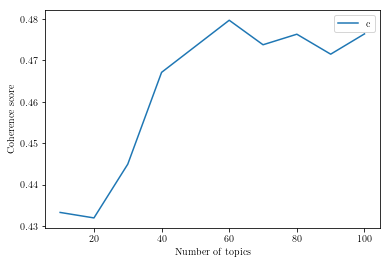

In [172]:
# Show graph
import matplotlib.pyplot as plt
limit=110; start=10; step=10;
x = range(start, limit, step)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig('coherence_values10_100.pdf')

In [173]:
coherence_values

[0.43329527467013085,
 0.4319703404414361,
 0.4449466595207501,
 0.46711493186138087,
 0.47340712262082507,
 0.4796977373413427,
 0.47377854445231277,
 0.47632554462691434,
 0.471505621841513,
 0.47640685640165814]

In [71]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.3291
Num Topics = 35  has Coherence Value of 0.3291
Num Topics = 60  has Coherence Value of 0.3291
Num Topics = 85  has Coherence Value of 0.3291
Num Topics = 110  has Coherence Value of 0.3291
Num Topics = 135  has Coherence Value of 0.3291
Num Topics = 160  has Coherence Value of 0.3291
Num Topics = 185  has Coherence Value of 0.3291


In [34]:
rows = []
for topic in range(0, N_TOPICS):
    words = lda.show_topic(topic, 10)
    topic_n_words = ' '.join([word[0] for word in words])
    print('Topic {}: {}'.format(str(topic), topic_n_words))
    rows.append([str(topic), topic_n_words])
keys = pd.DataFrame(rows, columns=['topic', 'words'])

Topic 0: viva onze lof hemel grote toch stem dies godes wereld
Topic 1: god gods heer eeuwig och rein recht zonden geloof altijd
Topic 2: hert ach 'k nooit pijn min lief mee zin zie
Topic 3: ’ ‘ hebben hert heel kwaad mijne deur dijn haast
Topic 4: ze je weet jou vier il geld ieder pas zig
Topic 5: leven god geest naa af voort gemoed zich oog kracht
Topic 6: onder dien heer elk hoog licht hun zich schoot hand
Topic 7: iager agar weg vrij herder 'k lust vast schone ziele
Topic 8: vreugd liefde bloed enen zijnen gheen ander brood ogen gezicht
Topic 9: kwam zien hart doe zag sou man sprak dragen kost


In [42]:
transformed_docs = lda.load_document_topics()
docs = [[texts[indx]] + [p[1] for p in doc] for indx, doc in enumerate(transformed_docs)]
composition = pd.DataFrame(docs, columns=['document_id'] + ['topic {}'.format(x) for x in range(0, N_TOPICS)])
composition.head()

,document_id,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9
0,VARDnormalized/varded50/186989.txt,0.118644,0.110169,0.050847,0.084746,0.127119,0.152542,0.067797,0.135593,0.084746,0.067797
1,VARDnormalized/varded50/3644.txt,0.098361,0.284153,0.065574,0.092896,0.103825,0.076503,0.071038,0.060109,0.076503,0.071038
2,VARDnormalized/varded50/38949.txt,0.048913,0.054348,0.027174,0.081522,0.048913,0.070652,0.038043,0.059783,0.059783,0.510870
3,VARDnormalized/varded50/114233.txt,0.049383,0.111111,0.104938,0.098765,0.049383,0.043210,0.154321,0.086420,0.271605,0.030864
4,VARDnormalized/varded50/19987.txt,0.034286,0.034286,0.028571,0.114286,0.600000,0.028571,0.034286,0.045714,0.040000,0.040000
